In [1]:
import geopandas as gpd
import pandas as pd
import sys
import os

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm_notebook

In [3]:
from scipy.spatial.distance import pdist

In [4]:
nycnodes = os.path.join("data","new-york","nodes.geojson")
nodes = gpd.read_file(nycnodes)

In [5]:
node_points = np.array([nodes.geometry.x, nodes.geometry.y]).T

In [6]:
node_points

array([[-73.98314175,  40.74296539],
       [-73.9832596 ,  40.74301792],
       [-73.98338672,  40.74307519],
       ...,
       [-73.95880628,  40.79329541],
       [-73.95912707,  40.79330078],
       [-73.95949321,  40.7934148 ]])

In [7]:
distances = pdist(node_points)

In [8]:
# plt.hist(distances, bins=500, color="black")

# plt.title("Histogram of Distances between Images")
# plt.xlabel("Meters")
# plt.ylabel("Count")
# plt.show()

In [9]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
from src.neighbor_identification import neighbors

In [11]:
import networkx as nx

In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
np.arange(0,10,2)

array([0, 2, 4, 6, 8])

In [14]:
from src.graph_construction import graph
nycgraph, rebuild_info = graph(
    "new-york",
    neighbor_radius=200,
    building_buffer=50,
    test_percent=15
)

In [15]:
nycgraph

HeteroData(
  pano={ x=[59771, 6] },
  footprint={
    x=[9637, 1],
    y=[22237],
    train_mask=[9637],
    test_mask=[9637]
  },
  (footprint, contains, pano)={ edge_index=[2, 200467] },
  (pano, links, pano)={ edge_index=[2, 11409473] },
  (pano, rev_contains, footprint)={ edge_index=[2, 200467] }
)

In [16]:
def lcc_vis(node_data, radius_list = np.arange(0,200,5)):
    connected_components = []

    for radius in tqdm_notebook(radius_list):
        edge_list = neighbors(
            node_data,
            radius = radius
        )
        G = nx.from_edgelist(edge_list.detach().cpu().numpy().T)
        G.remove_nodes_from(list(nx.isolates(G)))
        graph_components = list(nx.connected_components(G))
        connected_components.append(len(graph_components))

#     plt.step(
#         radius_list[1:],
#         connected_components[1:],
#         color="black"
#     )

    return radius_list[1:], connected_components[1:]

In [17]:
austingraph, austin_rebuild_info = graph(
    "austin",
    neighbor_radius=200,
    building_buffer=50,
    test_percent=15
)

In [18]:
sfgraph, sf_rebuild_info = graph(
    "san-fransisco",
    neighbor_radius=200,
    building_buffer=50,
    test_percent=15
)

In [19]:
sfgraph

HeteroData(
  pano={ x=[6808, 6] },
  footprint={
    x=[1521, 1],
    y=[9562],
    train_mask=[1521],
    test_mask=[1521]
  },
  (footprint, contains, pano)={ edge_index=[2, 11233] },
  (pano, links, pano)={ edge_index=[2, 624748] },
  (pano, rev_contains, footprint)={ edge_index=[2, 11233] }
)

In [20]:
sX, sY = lcc_vis(sf_rebuild_info['node_data'])

/tmp/ipykernel_37608/4189049934.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for radius in tqdm_notebook(radius_list):


  0%|          | 0/40 [00:00<?, ?it/s]

In [21]:
aX, aY = lcc_vis(austin_rebuild_info['node_data'])

/tmp/ipykernel_37608/4189049934.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for radius in tqdm_notebook(radius_list):


  0%|          | 0/40 [00:00<?, ?it/s]

In [22]:
nX, nY = lcc_vis(rebuild_info['node_data'])

/tmp/ipykernel_37608/4189049934.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for radius in tqdm_notebook(radius_list):


  0%|          | 0/40 [00:00<?, ?it/s]

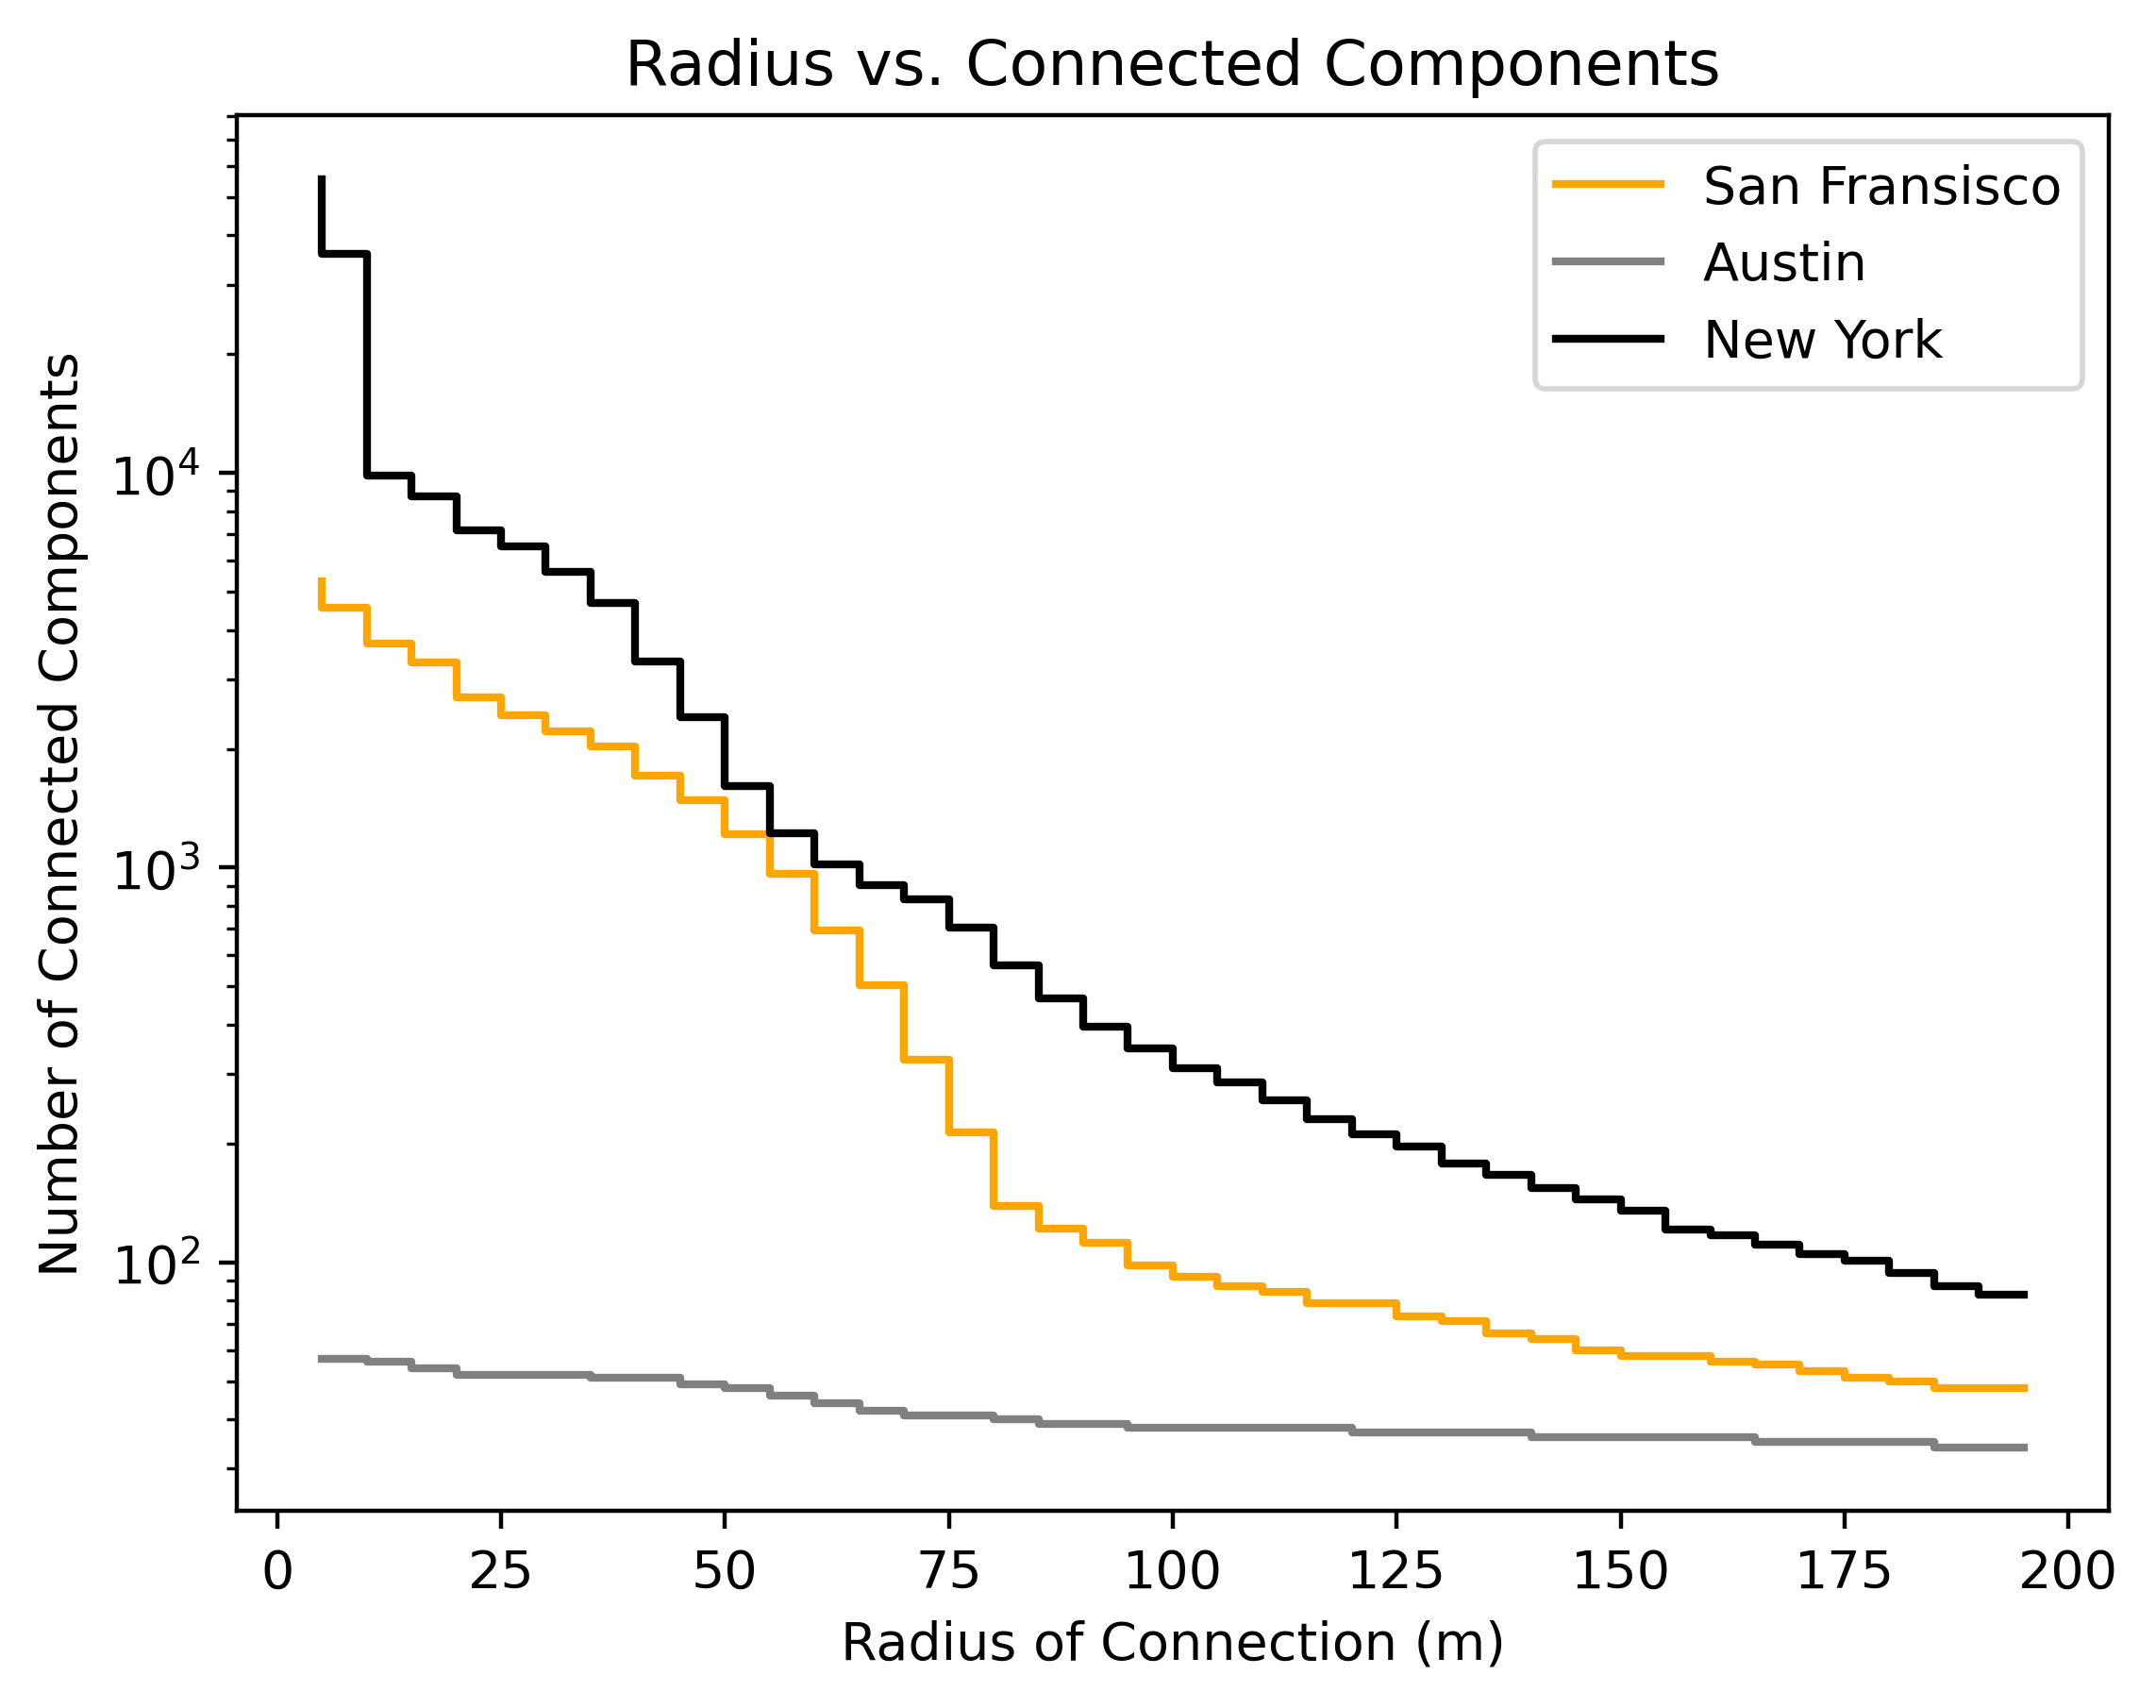

In [23]:
# Plotting both the curves simultaneously
fig, ax = plt.subplots(dpi=400)

ax.step(sX, sY, color="orange", label="San Fransisco")
ax.step(aX, aY, color='gray', label='Austin')
ax.step(nX, nY, color='black', label='New York')
  
plt.yscale("log")

plt.xlabel("Radius of Connection (m)")
plt.ylabel("Number of Connected Components")
plt.title("Radius vs. Connected Components")

plt.legend()
plt.savefig("connected-component-history.png")

plt.show()

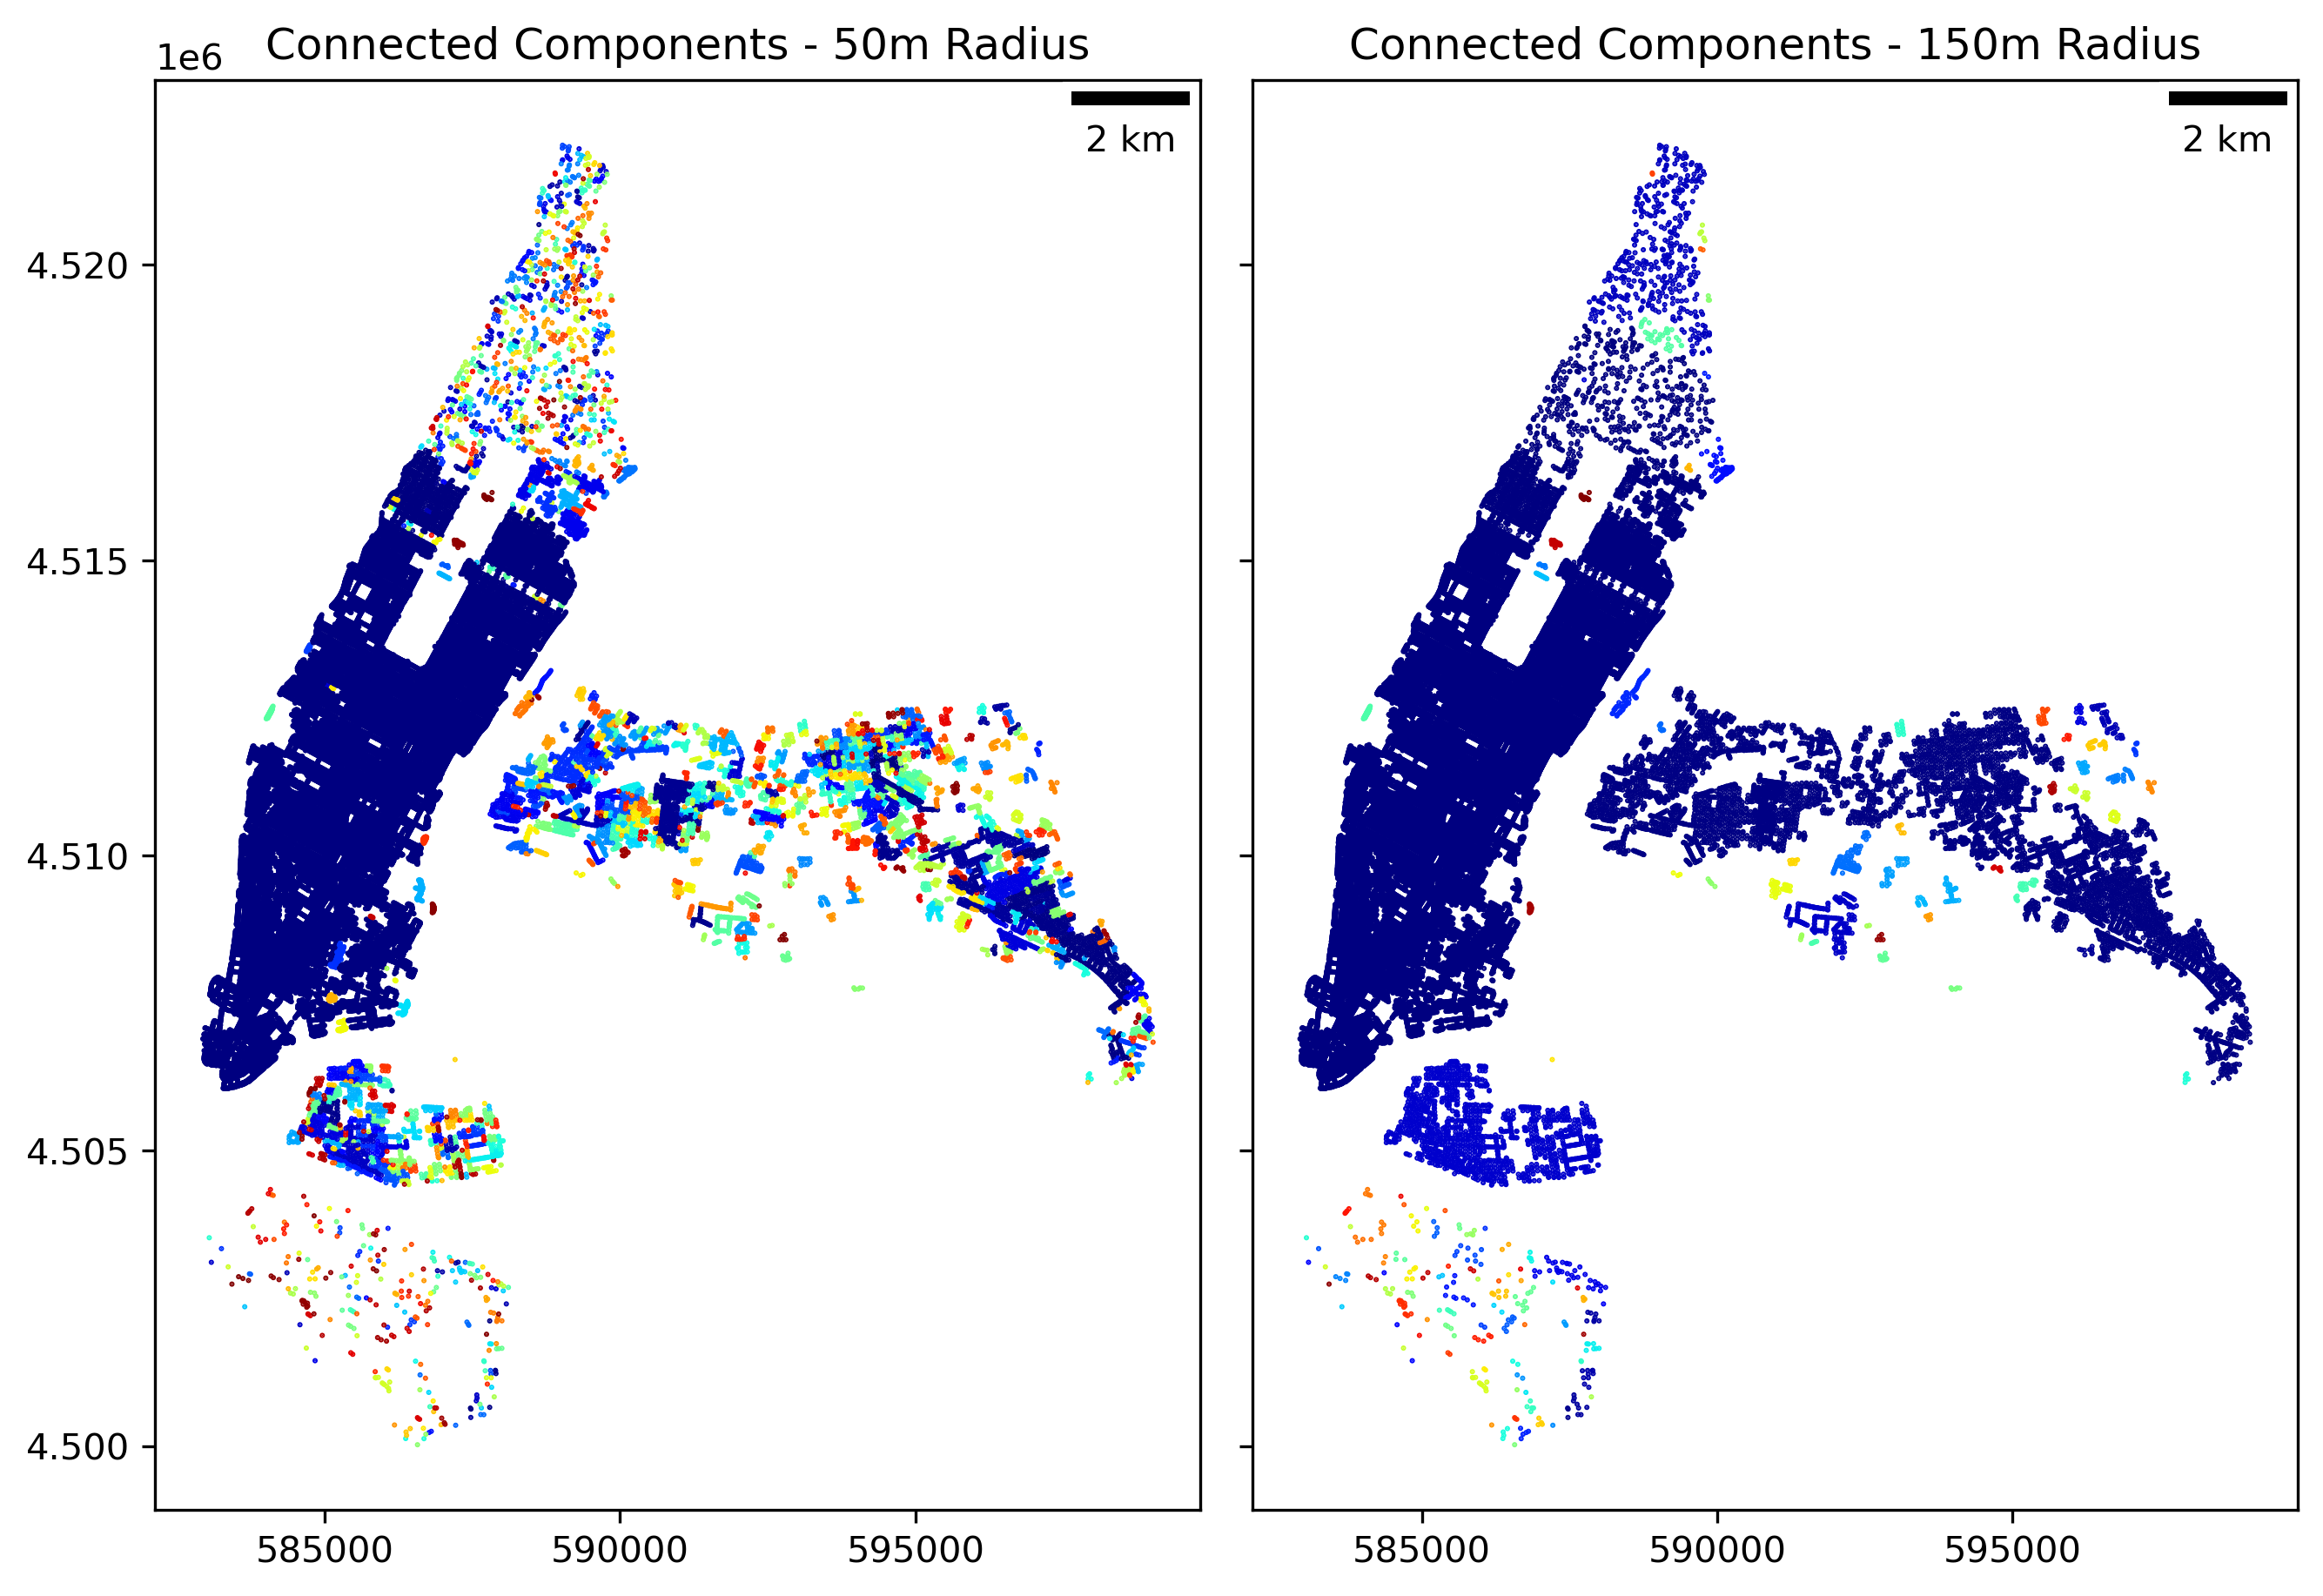

In [30]:
import copy
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar

color_thing = plt.cm.jet

fig, (ax1, ax2) = plt.subplots(
    1, 2, 
    sharex=True, 
    sharey=True, 
    figsize=(9, 7),
    dpi=300
)
plt.locator_params(axis='x', nbins=4)

### section 1 - showing the connected components of 10 meter radius
test_radius = 50
edge_list = neighbors(
    rebuild_info['node_data'],
    radius = test_radius
)
G = nx.from_edgelist(edge_list.detach().cpu().numpy().T)
graph_components = list(nx.connected_components(G))

color_arr = np.repeat(["#FF0000"], len(rebuild_info['node_data']))

for c,component in enumerate(graph_components):
    cterm = c / len(graph_components)
    color_arr[np.array(list(component))] = matplotlib.colors.to_hex(
        color_thing(cterm), 
        keep_alpha=True
    )
    
nodedata = rebuild_info['node_data']
nodedata.plot(markersize=0.2, ax=ax1, color=color_arr)
ax1.set_title(f"Connected Components - {test_radius}m Radius")

### section 2 - showing the connected components of larger radius
test_radius = 150
edge_list = neighbors(
    rebuild_info['node_data'],
    radius = test_radius
)
G = nx.from_edgelist(edge_list.detach().cpu().numpy().T)
graph_components = list(nx.connected_components(G))

color_arr = np.repeat(["#FF0000"], len(rebuild_info['node_data']))

for c,component in enumerate(graph_components):
    cterm = c / len(graph_components)
    color_arr[np.array(list(component))] = matplotlib.colors.to_hex(
        color_thing(cterm), 
        keep_alpha=True
    )
    
nodedata.plot(markersize=0.2, ax=ax2, color=color_arr)
ax2.set_title(f"Connected Components - {test_radius}m Radius")

ax1.add_artist(ScaleBar(1))
ax2.add_artist(ScaleBar(1))

plt.tight_layout()

plt.savefig('nyc_components.png')
plt.show()

In [30]:
G = nx.from_edgelist(nycgraph['pano','links','pano']['edge_index'].detach().cpu().numpy().T)
G.remove_nodes_from(list(nx.isolates(G)))

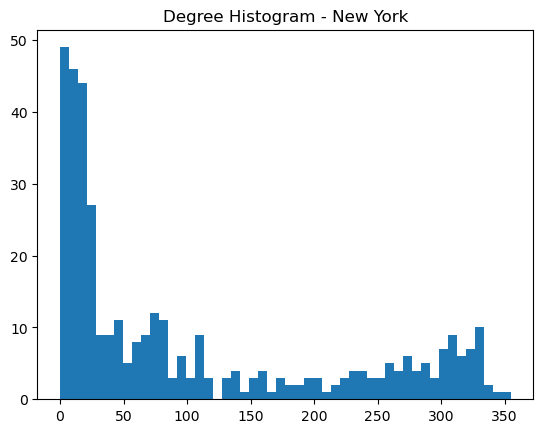

In [31]:
plt.hist(nx.degree_histogram(G), bins=50)

plt.title("Degree Histogram - New York")
plt.show()

In [76]:
def graph_statistics(graphobject, graphname):
    G = nx.from_edgelist(graphobject['pano','links','pano']['edge_index'].detach().cpu().numpy().T)
#     G.remove_nodes_from(list(nx.isolates(G)))
    
    return {
        "Density": nx.density(G),
        "Edges": nx.number_of_edges(G),
        "Nodes": nx.number_of_nodes(G),
        "Assortivity": nx.degree_assortativity_coefficient(G),
        "Transitivity": nx.transitivity(G),
        "Omega": nx.omega(G)
    }

In [77]:
nyc_nxgraph = nx.from_edgelist(nycgraph['pano','links','pano']['edge_index'].detach().cpu().numpy().T)

In [78]:
## also to compare a bit against a random, er graph with the same number of edges and nodes as nyc
total_possible_edges = (nx.number_of_nodes(nyc_nxgraph) * ((nx.number_of_nodes(nyc_nxgraph) - 1))) / 2
edge_probability = nx.number_of_edges(nyc_nxgraph) / total_possible_edges

random_graph = nx.erdos_renyi_graph(nycgraph.num_nodes, edge_probability)

In [79]:
nx.number_of_nodes(random_graph)

45405

In [80]:
nycgraph.num_nodes

45405

In [ ]:
randomstats = {
    "Density": nx.density(random_graph), 
    "Edges": nx.number_of_edges(random_graph),
    "Nodes": nx.number_of_nodes(random_graph),
    "Assortivity": nx.degree_assortativity_coefficient(random_graph),
    "Transitivity": nx.transitivity(random_graph),
    "Omega": nx.omega(random_graph)
}
randomstats

In [ ]:
nystats = graph_statistics(nycgraph, "New York")
nystats

In [ ]:
sfstats = graph_statistics(sfgraph, "San Fransisco")
sfstats

In [ ]:
austats = graph_statistics(austingraph, "Austin")
austats

In [ ]:
statsdf = pd.DataFrame([randomstats, nystats, sfstats, austats], index=['Erdős–Rényi','New York','San Fransisco','Austin'])

In [ ]:
with pd.option_context('display.float_format', '{:,.3f}'.format):
   print(statsdf)

In [ ]:
G = nx.from_edgelist(nycgraph['pano','links','pano']['edge_index'].detach().cpu().numpy().T)
G.remove_nodes_from(list(nx.isolates(G)))

In [ ]:
G

In [ ]:
nx.is_connected(G)

In [ ]:
graph_components = list(nx.connected_components(G))

In [ ]:
len(graph_components)